# General linear model on fMRI data



## First level analysis

Analysis performed on a level of single subject (individual).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_design_matrix, plot_contrast_matrix
from nistats.thresholding import map_threshold
from nistats.reporting import get_clusters_table

In [2]:
# Load a lable with events
events_path = "../fMRI_BIDS_rhymejudgment/sub-01/func/sub-01_task-rhymejudgment_events.tsv"
events = pd.read_csv(events_path, sep="\t")
events.head()

,onset,duration,trial_type
0,20.001,2.0,word
1,22.501,2.0,word
2,25.001,2.0,word
3,27.501,2.0,word
4,30.001,2.0,word


In [3]:
# Load preprocessed fMRI image
fmri_img = "../fMRI_BIDS_rhymejudgment/derivatives/fmriprep/sub-01/func/sub-01_task-rhymejudgment_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
confounds_path = "../fMRI_BIDS_rhymejudgment/derivatives/fmriprep/sub-01/func/sub-01_task-rhymejudgment_desc-confounds_regressors.tsv"
confounds = pd.read_csv(confounds_path, sep="\t")
motion = confounds[["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]]

In [45]:
t_r = 2 # repetition time (TR)
first_level_model = FirstLevelModel(t_r, 
                                    hrf_model='spm', 
                                    high_pass=.01,
                                    smoothing_fwhm=6)

first_level_model = first_level_model.fit(fmri_img, events=events)

In [6]:
design_matrix = first_level_model.design_matrices_[0]

# Print head of the dataframe
design_matrix.head()

,pseudoword,word,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,constant
0.0,0.0,0.0,0.111798,0.111782,0.111755,0.111717,0.111669,0.111609,1.0
2.0,0.0,0.0,0.111755,0.111609,0.111367,0.111028,0.110593,0.110062,1.0
4.0,0.0,0.0,0.111669,0.111265,0.110593,0.109655,0.108453,0.106989,1.0
6.0,0.0,0.0,0.111539,0.110749,0.109436,0.107606,0.105268,0.102433,1.0
8.0,0.0,0.0,0.111367,0.110062,0.107899,0.104893,0.101069,0.096457,1.0


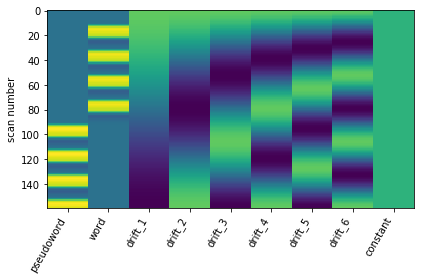

In [7]:
# Plot design matrix
plot_design_matrix(design_matrix)

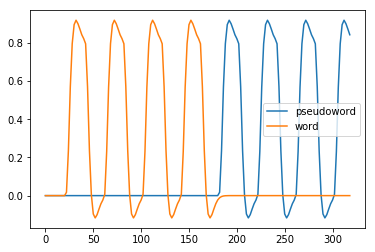

In [15]:
# Print timeseries of task-HRF data
plt.plot(design_matrix[['pseudoword', 'word']])
plt.legend(['pseudoword', 'word'])

In [23]:
# Create conditions
conditions = {'pseudoword': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0]), 
              'word': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0])}

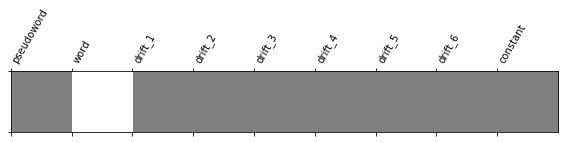

In [24]:
# Create contrasts
word_minus_pseudoword = conditions['word'] - conditions['pseudoword']
word_effect = conditions['word']

# Plot contrast matrix
plot_contrast_matrix(word_effect, design_matrix=design_matrix)

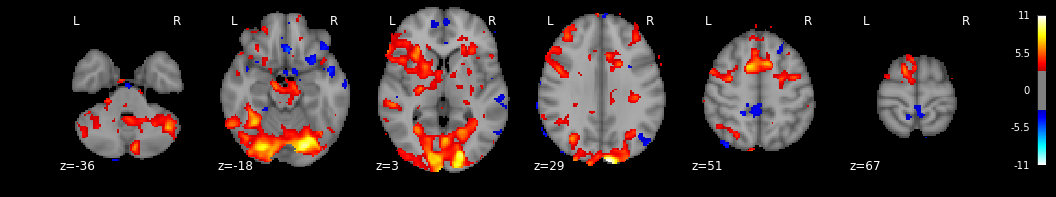

In [29]:
# Calculate statistic test for selected contrast (brain activity for word processing)
z_map = first_level_model.compute_contrast(word_effect,
                                  output_type='z_score')
plot_stat_map(z_map, threshold=3,
              display_mode='z', cut_coords=6, black_bg=True)
plt.show()

Uncorrected p<0.001 threshold: 5.048


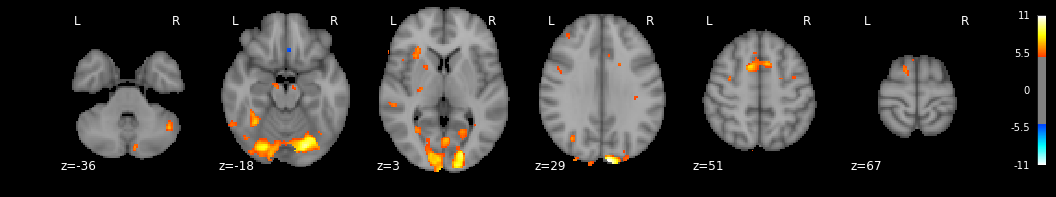

In [28]:
# Threshold z-maps to correct for multiple comparisons
_, threshold = map_threshold(z_map, alpha=.05, height_control='bonferroni')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)

plot_stat_map(z_map, threshold=threshold,
              display_mode='z', cut_coords=6, black_bg=True)
plt.show()

In [35]:
# Get cluster table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,7.5,-94.5,29.5,10.977340,45776
1,1a,19.5,-76.5,-18.5,9.844453,
2,1b,-24.5,-78.5,-20.5,9.343041,
3,1c,19.5,-90.5,5.5,9.246269,
4,2,-32.5,-48.5,-16.5,8.453494,1472
5,2a,-36.5,-58.5,-24.5,5.698592,
6,3,-40.5,-0.5,37.5,8.323886,3328
7,3a,-52.5,1.5,45.5,7.489890,
8,3b,-32.5,-4.5,57.5,6.687034,
9,3c,-32.5,-6.5,45.5,6.321622,


## Repeat GLM analysis with design matrix extended by 6 motion parameters

In [34]:
# Repeat everything with motion as nuisance regressors.
first_level_model_motion = first_level_model.fit(fmri_img, events=events, confounds=motion)

design_matrix_motion = first_level_model.design_matrices_[0]

# Print head of the dataframe
design_matrix_motion.head()

,pseudoword,word,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,constant
0.0,0.0,0.0,-0.000081,-0.060488,-0.186893,0.002502,-0.000822,-0.000621,0.111798,0.111782,0.111755,0.111717,0.111669,0.111609,1.0
2.0,0.0,0.0,-0.000095,-0.017757,-0.097059,0.001619,-0.000964,-0.000202,0.111755,0.111609,0.111367,0.111028,0.110593,0.110062,1.0
4.0,0.0,0.0,-0.000099,0.000539,-0.050085,0.001288,-0.000964,-0.000246,0.111669,0.111265,0.110593,0.109655,0.108453,0.106989,1.0
6.0,0.0,0.0,-0.006923,0.023834,-0.036712,0.001190,-0.000884,0.000039,0.111539,0.110749,0.109436,0.107606,0.105268,0.102433,1.0
8.0,0.0,0.0,0.007688,0.016427,0.015656,0.000609,-0.000964,0.000216,0.111367,0.110062,0.107899,0.104893,0.101069,0.096457,1.0


In [37]:
# Create conditions 
conditions_motion = {'pseudoword': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 
                     'word': np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
                     'trans_y': np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

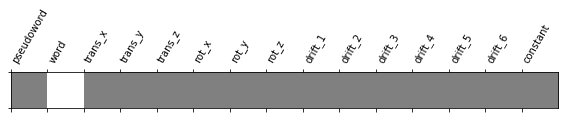

In [40]:
# Create contrasts
word_minus_pseudoword_motion = conditions_motion['word'] - conditions_motion['pseudoword']
word_effect_motion = conditions_motion['word']
trans_y = conditions_motion['trans_y']

# Plot contrast matrix
plot_contrast_matrix(word_effect_motion, design_matrix=design_matrix_motion)

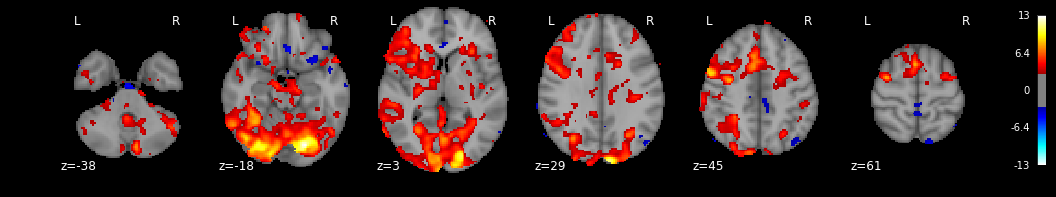

In [41]:
# Calculate statistic test for selected contrast (brain activity for word processing)
z_map_motion = first_level_model.compute_contrast(word_effect_motion,
                                  output_type='z_score')
plot_stat_map(z_map_motion, threshold=3,
              display_mode='z', cut_coords=6, black_bg=True)
plt.show()

Uncorrected p<0.001 threshold: 5.048


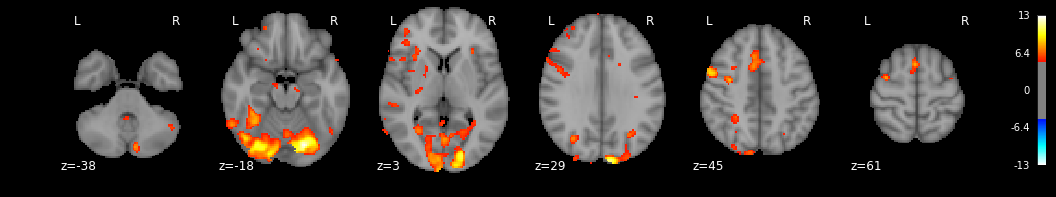

In [42]:
# Threshold z-maps to correct for multiple comparisons
_, threshold = map_threshold(z_map_motion, alpha=.05, height_control='bonferroni')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)

plot_stat_map(z_map_motion, threshold=threshold,
              display_mode='z', cut_coords=6, black_bg=True)
plt.show()

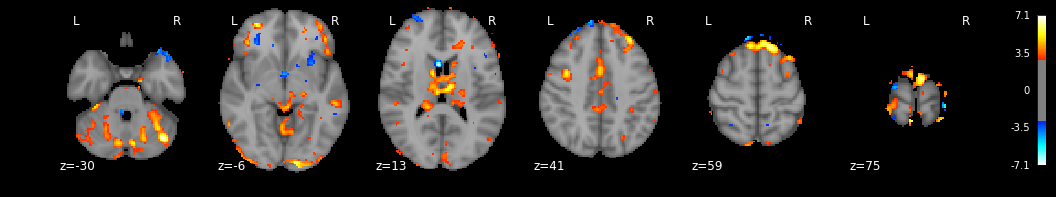

In [44]:
# Run contrast for motion effect (which voxels are associated with motion (translation in Y direction)?)
z_map_motion_trans = first_level_model.compute_contrast(trans_y,
                                  output_type='z_score')
plot_stat_map(z_map_motion_trans, threshold=3,
              display_mode='z', cut_coords=6, black_bg=True)
plt.show()